# Implementing a CycleGAN : Apple2Orange and Orange2Apple



## Explanation

In this notebook, we will implement a CycleGAN from sratch using PyTorch. We will train a model to translate images of apples to oranges and vice versa.

The CycleGAN model is composed of two generators and two discriminators. The generators are responsible for translating images from one domain to another, while the discriminators are responsible for distinguishing between translated images and real images. The generators and discriminators are trained in an adversarial manner, where the generators try to fool the discriminators and the discriminators try to distinguish between real and fake images. You can see an overview of the CycleGAN model in the figure below:
<img src="https://junyanz.github.io/CycleGAN/images/cyclegan_blogs.jpg">

You can refer to the [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) for more information.

The preservation of key features in the image translation process is done thanks to the **cycle consistency loss**. In fact, not only an image is translated to another domain, but this generated image is translated back so that the models should return the same kind of images.

## Key differences between a traditional GAN and a CycleGAN

- Traditional GANs are composed of 1 generator and 1 discriminator. The generator tries to fool the discriminator that aims to correctly recognize true and fake images. CycleGan has 2 discriminators and 2 generators.

- Traditional GANs are mainly built to generate realistic data. CycleGAN, on the other hand, is designed for unpaired image-to-image translation. It aims to learn mappings between two domains without having a one-to-one correspondence between images in the two domains.

- CycleGANs introduce cycle consistency loss, in addition to adversarial loss. The cycle consistency loss enforces that translating from one domain to another and then back should result in the original image

## Losses

Here, we will define various losses : 1. 2 losses of the generators
2. 2 losses of the discriminator
3. losses of identity
4. cycling losses

##

## Project Outline

1. Data Import
2. Generator Dataset Creation
3. Generator and Discriminator Models
4. Training the model
5. Testing the model

# I. Data Import

You can first retrieve the data by executing the following cells:

In [ ]:
!wget https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true

--2024-01-15 08:21:53--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/datasets/download_cyclegan_dataset.sh?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/raw/master/datasets/download_cyclegan_dataset.sh [following]
--2024-01-15 08:21:53--  https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/raw/master/datasets/download_cyclegan_dataset.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/master/datasets/download_cyclegan_dataset.sh [following]
--2024-01-15 08:21:53--  https://raw.githubusercontent.com/junyanz/pytorch-CycleGAN-and-pix2pix/master/datasets/download_cyclegan_dataset.sh
Resolving raw.githubusercontent.com (raw.githubuserconten

In [ ]:
!mkdir datasets  #creation of a new directory named "datasets"
!bash ./download_cyclegan_dataset.sh?raw=true apple2orange

Specified [apple2orange]
for details.

--2024-01-15 08:21:54--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘./datasets/apple2orange.zip’

./datasets/apple2or 100%[===================>]  74.82M  1.71MB/s    in 42s     

2024-01-15 08:22:36 (1.79 MB/s) - ‘./datasets/apple2orange.zip’ saved [78456409/78456409]

Archive:  ./datasets/apple2orange.zip
   creating: ./datasets/apple2orange/trainA/
  inflating: ./datasets/apple2orange/trainA/n07740461_6908.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_7635.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_586.jpg  
  inflating: ./datasets/apple2orange/trainA/n07740461_9813.jpg  
  inflating: ./datasets/apple2o

# II. Dataset creation

In [ ]:
import os
import gc
import random
import torch
import torch.utils.data as data
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from torch.optim import lr_scheduler
from IPython.display import clear_output
from torch.utils.data import Subset

## II.1. Useful Functions

Some useful functions that we will use later:
1. denormalize : function to plot the pictures in RBG after training
2. deprocess : Function that changes the order of dimensions from the PyTorch convention to the Numpy one.

In [ ]:
def denormalize(images, std=0.5, mean=0.5):
    # For plot
    images = (images * std) + mean
    return images

def deprocess(input_tensor):
    '''
    Function that changes the order of dimensions from the PyTorch convention (channel, height, width)
    to the NumPy convention (height, width, channel)
    or (batch_size, channels, height, width) to (batch_size, height, width, channels)'''

    if len(input_tensor.shape) == 3:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (1, 2, 0))
    elif len(input_tensor.shape) == 4:
        return np.transpose(denormalize(input_tensor.to(device).cpu()), (0, 2, 3, 1))

## II.2 Generator Dataset

During the training, the get_item function of the class is called for each input. To optimize the training, we don't `open` the image in the get_item function, but all image are alreay "opened" in the init function.  

In [ ]:
class GeneratorDataset(data.Dataset):

    ''' Dataset that loads the images from a path directory an applies some given transformations'''

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir #path as string
        self.transform = transform #given transformations

        self.filenames = np.array([filename for filename in os.listdir(root_dir)])  #just the names of the files
        self.files_paths = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir)] #paths of every file

        # List to store pixel data for each image
        self.images = []

        # Load and store pixel data for each image
        for path in self.files_paths:
            image = Image.open(path)
            self.images.append(image)

    def __len__(self):

        return len(self.filenames)


    def __getitem__(self, idx):


        image = self.images[idx] #call a PIL object
        tensor_image = self.transform(image) #there is a toTensor() in the transformations

        return tensor_image

## II.3 Dataset and Dataloaders instanciations

We will now create the dataset objects for the training and testing sets:

In [ ]:
DATASET = 'apple2orange'
DATASET_PATH = os.path.join("datasets", DATASET) # # os.path.join() automatically handles the correct path separator based on the operating system
OUTPUT_PATH = 'outputs'

base_logdir = os.path.join("logs", 'pytorch') # Sets up a log directory.
RESIZE_SHAPE = 128 # Resized image size for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataset objects
preprocess_train_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #means values for each RGB and each std
                           ])

preprocess_test_transformations = transforms.Compose([
                               transforms.Resize(RESIZE_SHAPE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

train_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainA"),
                           transform=preprocess_train_transformations)

train_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "trainB"),
                           transform=preprocess_train_transformations)

test_data_X = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testA"),
                           transform=preprocess_test_transformations)

test_data_Y = GeneratorDataset(root_dir=os.path.join(DATASET_PATH, "testB"),
                           transform=preprocess_test_transformations)

print("Found {} images in {}".format(len(train_data_X), 'trainA'))
print("Found {} images in {}".format(len(train_data_Y), 'trainB'))
print("Found {} images in {}".format(len(test_data_X), 'testA'))
print("Found {} images in {}".format(len(test_data_Y), 'testB'))

Found 995 images in trainA
Found 1019 images in trainB
Found 266 images in testA
Found 248 images in testB


In order to speed up the training process, we will use a subset of the training data:

In [ ]:
random.seed(2)

N_IMAGES_TO_SAMPLE = 400

indices_X = random.sample(range(len(train_data_X)), N_IMAGES_TO_SAMPLE)
indices_Y = random.sample(range(len(train_data_Y)), N_IMAGES_TO_SAMPLE)

train_data_X = Subset(train_data_X, indices_X)
train_data_Y = Subset(train_data_Y, indices_Y)

# III. Generator and Discriminator Models

We will now implement the backbone for the generator and the discriminator. We will use the Resnet generator that is explained in the research paper. We will use a ResidualBlock for the generator backbone (and not the Bottleneck one).

The first block of our ResNet generator, before downsampling, is [`ReflectionPad2d`, `Conv2d`, `InstanceNorm2d`, `Relu`]. We can wonder what is done to dimensions and channels size. The next code snippet show that no dimensions are altered. We begin with a 12x12 RGB picture.

In [ ]:
image_shape = 12 #(12x12 RGB picture)
RGB = 3

refl = nn.ReflectionPad2d(RGB)
conv = nn.Conv2d(RGB, 64, 7) #We choose to put 64 channels
norm = nn.InstanceNorm2d(64)

input = torch.arange(RGB*image_shape*image_shape, dtype=torch.float).reshape(1, RGB, image_shape, image_shape) #creation of a fake picture
print(input.shape)
print(refl(input).shape)
print("We keep spatial dimension")
print(conv(refl(input)).shape)

print("Normalization doesn't change the shape")
print(norm(conv(refl(input))).shape)

torch.Size([1, 3, 12, 12])
torch.Size([1, 3, 18, 18])
We keep spatial dimension
torch.Size([1, 64, 12, 12])
Normalization doesn't change the shape
torch.Size([1, 64, 12, 12])


## III.1 Model classes

In [ ]:
##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):

    def __init__(self, in_features):

        super(ResidualBlock, self).__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_features)

    def forward(self, x):

        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class GeneratorResNet(nn.Module):
    """ Generator of images.
    In terms of dimensions : if the input is (3*128*128).
    After initial 7x7 conv block, we augment the channels: (64*128*128)
    Then 2 (3x3) conv layer, we /2 the dimension: (128*64*64) -> (216*32*32)
    Then we stack a certain number of residual blocks (216* )
    Finally we upsample from (216*32*32) to (3*128*128) in the inverse way.  """
    def __init__(self, input_channel, n_blocks, filters, output_channel):
        super(GeneratorResNet, self).__init__()

        # Initial convolution block (Reflection + Conv2d preserves spatial dimensions but augments the channel size)
        model = [
            nn.ReflectionPad2d(input_channel),
            nn.Conv2d(input_channel, filters, 7), # 7x7 initial filter
            nn.InstanceNorm2d(filters), #normalization on each channel
            nn.ReLU(inplace=True),
        ]
        in_features = filters #for example, beginning with 64 channels

        # Downsampling : dimensions reductions and filters number augmentation
        for _ in range(2):
            filters *= 2 #we give twice as more channels
            model += [
                nn.Conv2d(in_features, filters, 3, stride=2, padding=1), #output dimension rounded down so it's /2
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResidualBlock(filters)]

        # Upsampling
        for _ in range(2):
            filters //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, filters, 3, stride=1, padding=1),
                nn.InstanceNorm2d(filters),
                nn.ReLU(inplace=True),
            ]
            in_features = filters

        # Output layer
        model += [nn.ReflectionPad2d(output_channel), nn.Conv2d(filters, output_channel, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
##############################
#        Discriminator
##############################

class Discriminator(nn.Module):
    def __init__(self, input_channel, filters):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channel, filters, normalize=False),
            *discriminator_block(filters, filters * 2),
            *discriminator_block(filters * 2, filters * 4),
            *discriminator_block(filters * 4, filters *8),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(filters *8, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

## III.2 Models instanciation

We will now instantiate the generator and discriminator models:

In [ ]:
G_XtoY = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)
G_YtoX = GeneratorResNet(input_channel=3, output_channel=3, filters=64, n_blocks=9).to(device)

In [ ]:
Dx = Discriminator(input_channel=3, filters=64).to(device)
Dy = Discriminator(input_channel=3, filters=64).to(device)

## III.3 Weights initialization
Still according to the paper, we need to randomly initialize the weights for all the convolutional layers in the generators and the discriminators with values sampled from a normal distribution (mean=0.0, std=0.02), and initialize their bias to 0.0.

In [ ]:
import torch.nn.init as init

def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.normal_(m.weight.data, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias.data, 0.0)

# ============================
# Initialize the values of the models
# ============================
# Initialize the values of the two generators
init_weights(G_XtoY)
init_weights(G_YtoX)

# Initialize the values of the two discriminators
init_weights(Dx)
init_weights(Dy)

# IV. Training

We will define the hyperparameters used for training our CycleGAN model. The model should run on the T4 GPU provided by Google Colab. You may need to adjust the batch size to fit the model on other GPUs:

In [ ]:
BATCH_SIZE = 10
EPOCHs = 30
SAVE_EVERY_N_EPOCH = 5

We will now define the data loaders for the training and testing sets:

In [ ]:
train_image_loader_X = torch.utils.data.DataLoader(train_data_X, batch_size=BATCH_SIZE,
                                                    shuffle=True, num_workers=0)
train_image_loader_Y = torch.utils.data.DataLoader(train_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=0)
test_image_loader_X = torch.utils.data.DataLoader(test_data_X, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
test_image_loader_Y = torch.utils.data.DataLoader(test_data_Y, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

We will now extract some images from the test set to visualize the model's performance during training:

In [ ]:
id_sample_X = np.where(np.array(test_data_X.filenames) == "n07740461_11391.jpg")[0][0]
id_sample_Y = np.where(np.array(test_data_Y.filenames) == "n07749192_10081.jpg")[0][0]

sample_X = test_data_X[id_sample_X]
sample_Y = test_data_Y[id_sample_Y]

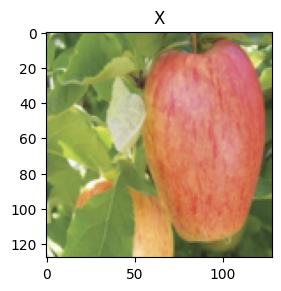

In [ ]:
plt.subplot(121)
plt.title('X')
plt.imshow(deprocess(sample_X))

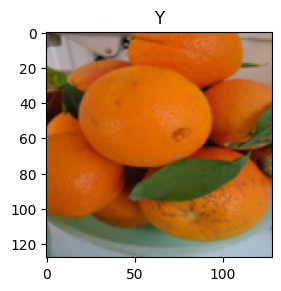

In [ ]:
plt.subplot(121)
plt.title('Y')
plt.imshow(deprocess(sample_Y))

We define our hyperparameters and optimizers :

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

LR = 0.00002
BETAS = (0.5, 0.999)


G_XtoY_optimizer = optim.Adam(G_XtoY.parameters(), lr=LR, betas = BETAS)
G_YtoX_optimizer = optim.Adam(G_YtoX.parameters(), lr=LR, betas = BETAS)

Dx_optimizer = optim.Adam(Dx.parameters(), lr=LR, betas = BETAS)
Dy_optimizer = optim.Adam(Dy.parameters(), lr=LR, betas = BETAS)

scheduler_XtoY = lr_scheduler.StepLR(G_XtoY_optimizer, step_size=3)
scheduler_YtoX = lr_scheduler.StepLR(G_YtoX_optimizer, step_size=3)
scheduler_Dx = lr_scheduler.StepLR(Dx_optimizer, step_size=3 )
scheduler_Dy = lr_scheduler.StepLR(Dy_optimizer, step_size=3)

## IV.1 Defining Losses

We will now implement the different loss functions used in CycleGANs:

In [ ]:
SOFT_FAKE_LABEL_RANGE =  [0.0, 0.3] # The label of fake label will be generated within this range.
SOFT_REAL_LABEL_RANGE = [0.7, 1.2] # The label of real label will be generated within this range.

The discriminator loss is defined by:
\begin{equation}
\mathcal{L}_{D} = \frac{1}{2} (\mathbb{E}_{y \sim p_{data}(y)}[(D_Y(y) - r_2)^2] + \mathbb{E}_{x \sim p_{data}(x)}[(D_Y(G_{XY}(x))-r_1)^2]) + \frac{1}{2} (\mathbb{E}_{x \sim p_{data}(x)}[(D_X(x) - r_2)^2] + \mathbb{E}_{y \sim p_{data}(y)}[(D_X(G_{YX}(y))-r_1)^2])
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_1$ and $r_2$ being the soft fake and real labels chosen from a uniform distribution within the ranges $[0.0, 0.3]$ and $[0.7, 1.2]$ respectively.

### IV.1.1 Discriminator loss

In [ ]:
def discriminator_loss(real_image, generated_image):
    ''' Loss of only one discriminator (X or Y). They need to be summed afterwards.
    real_image and generated_image are real numbers related to real and generated images :
    real_image can be Dy(y) or Dx(y)
    generated_image can be Dy(Gxy(x)) or Dx(Gyx(y)) '''

    dim_images = real_image.shape

    # Generate soft labels from uniform distribution
    r1 = torch.FloatTensor(dim_images).uniform_(SOFT_FAKE_LABEL_RANGE[0], SOFT_FAKE_LABEL_RANGE[1]).to(device)
    r2 = torch.FloatTensor(dim_images).uniform_(SOFT_REAL_LABEL_RANGE[0], SOFT_REAL_LABEL_RANGE[1]).to(device)

    loss = 0.5* ( F.mse_loss(real_image,r2)  + F.mse_loss(generated_image,r1) )

    return loss

### IV.1.2 Generator Loss

The generator loss is defined by:
\begin{equation}
\mathcal{L}_{G} = \mathbb{E}_{x \sim p_{data}(x)}(D_Y(G_{XY}(x)) - r_2)^2 + \mathbb{E}_{y \sim p_{data}(y)}(D_X(G_{YX}(y)) - r_2)^2
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, $D_X$ and $D_Y$ the two discriminators, and $r_2$ being the soft real label chosen from a uniform distribution within the range $[0.7, 1.2]$.

In [ ]:
def generator_loss(generated_image):

    ''' Loss of only one generator (X or Y). They need to be summed afterwards.
    generated_image is a real numbers related to a generated images.
     generated_image can be Dy(Gxy(x)) or Dx(Gyx(y)) '''

    dim_images = generated_image.shape #the output of the discriminator is 8x8 so we need to use its shape

    # Generate soft labels from uniform distribution
    r2 = torch.FloatTensor(dim_images).uniform_(SOFT_REAL_LABEL_RANGE[0], SOFT_REAL_LABEL_RANGE[1]).to(device)

    loss = F.mse_loss(generated_image,r2)

    return loss

### IV.1.3 Cycle Consistency Loss

In addition to the traditional loss functions used in GANs, CycleGANs also use two additional loss functions: cycle consistency loss and identity loss. We will use the same $\lambda$ for the two losses.

In [ ]:
LAMBDA = 10

The cycle consistency loss is defined by:
\begin{equation}
\mathcal{L}_{cyc} = \lambda\mathbb{E}_{x \sim p_{data}(x)}[||x - G_{YX}(G_{XY}(x))||_1] + \lambda\mathbb{E}_{y \sim p_{data}(y)}[||y - G_{XY}(G_{YX}(y))||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators and $\lambda$ being the weight for the cycle consistency loss.

In [ ]:
def cycle_consistency_loss(real_image, cycled_image):

    '''Cycled loss of only one image (x or y). They need to be summed afterwards.
    real_image and cycled_image are the images (as tensors pixels).
    real_image can be x or y
    generated_image can be Gyx(Gxy(x)) or Gxy(Gyx(y))'''

    loss = LAMBDA*F.l1_loss(real_image,cycled_image)
    return loss

### IV.1.4 Identity Loss

The identity loss is defined by:
\begin{equation}
\mathcal{L}_{id} = \frac{1}{2}\lambda\mathbb{E}_{x \sim p_{data}(x)}[||G_{YX}(x) - x||_1] + \frac{1}{2}\lambda\mathbb{E}_{y \sim p_{data}(y)}[||G_{XY}(y) - y||_1]
\end{equation}
with $p_{data}(x)$ being the distribution of images from the first domain, $p_{data}(y)$ being the distribution of images from the second domain, $G_{XY}$ and $G_{YX}$ being the two generators, and $\lambda$ being the weight for the identity loss.

In [ ]:
def identity_loss(real_image, generated_image):

    '''Identity loss of only one image (x or y). They need to be summed afterwards.
    real_image and cycled_image are the images (as tensors pixels).
    real_image can be x or y
    generated_image can be Gyx(x) or Gxy(Gyx(y))'''
    loss = 0.5*LAMBDA *F.l1_loss(real_image,generated_image)

    return loss

The total generator loss is defined by:
\begin{equation}
\mathcal{L}_{G_{tot}} = \mathcal{L}_{G} + \mathcal{L}_{cyc} + \mathcal{L}_{id}
\end{equation}
with $\mathcal{L}_{G_X}$ and $\mathcal{L}_{G_Y}$ being the generator loss for the two domains, $\mathcal{L}_{cyc}$ being the cycle consistency loss and $\mathcal{L}_{id}$ being the identity loss.

## IV.2. Saving Weights

We will now set the checkpoint path for saving the model:

In [ ]:
checkpoint_path = os.path.join("checkpoints", 'pytorch', DATASET, )

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

def save_training_checkpoint(epoch):
    state_dict = {
    'G_XtoY':G_XtoY.state_dict(),
    'G_YtoX':G_YtoX.state_dict(),
    'Dx':Dx.state_dict(),
    'Dy':Dy.state_dict(),
    'G_XtoY_optimizer':G_XtoY_optimizer.state_dict(),
    'G_YtoX_optimizer':G_YtoX_optimizer.state_dict(),
    'Dx_optimizer':Dx_optimizer.state_dict(),
    'Dy_optimizer':Dy_optimizer.state_dict(),
    'epoch': epoch
    }

    save_path = os.path.join(checkpoint_path, 'training-checkpoint')
    torch.save(state_dict, save_path)

# if a checkpoint exists, restore the latest checkpoint.
if os.path.isfile(os.path.join(checkpoint_path, 'training-checkpoint')):
    checkpoint = torch.load(os.path.join(checkpoint_path, 'training-checkpoint'))
    G_XtoY.load_state_dict(checkpoint['G_XtoY'])
    G_YtoX.load_state_dict(checkpoint['G_YtoX'])
    Dx.load_state_dict(checkpoint['Dx'])
    Dy.load_state_dict(checkpoint['Dy'])
    G_XtoY_optimizer.load_state_dict(checkpoint['G_XtoY_optimizer'])
    G_YtoX_optimizer.load_state_dict(checkpoint['G_YtoX_optimizer'])
    Dx_optimizer.load_state_dict(checkpoint['Dx_optimizer'])
    Dy_optimizer.load_state_dict(checkpoint['Dy_optimizer'])
    CURRENT_EPOCH = checkpoint['epoch']
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 30 restored!!


We also define a function that translated into an other domain given an already trained model.

In [ ]:
def generate_images(model, test_input):


    model = model.to(device)
    test_input = test_input.unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        generated_image = model(test_input)

    model.train() #need to put back the model for the other trainings

    return generated_image.squeeze(0)



And to plot them :

In [ ]:
def plot_images(original_X, generated_X, original_Y, generated_Y):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(deprocess(original_X))
    plt.title('Original X')

    plt.subplot(1, 4, 2)
    plt.imshow(deprocess(generated_X))
    plt.title('Generated XtoY')

    plt.subplot(1, 4, 3)
    plt.imshow(deprocess(original_Y))
    plt.title('Original Y')

    plt.subplot(1, 4, 4)
    plt.imshow(deprocess(generated_Y))
    plt.title('Generated YtoX')


    plt.show()

## IV.3 Training Loop

G_XtoY Loss :  0.4857 and G_YtoX Loss :  0.4715 
Dx Loss :  0.1031 and Dy Loss :  0.1036 


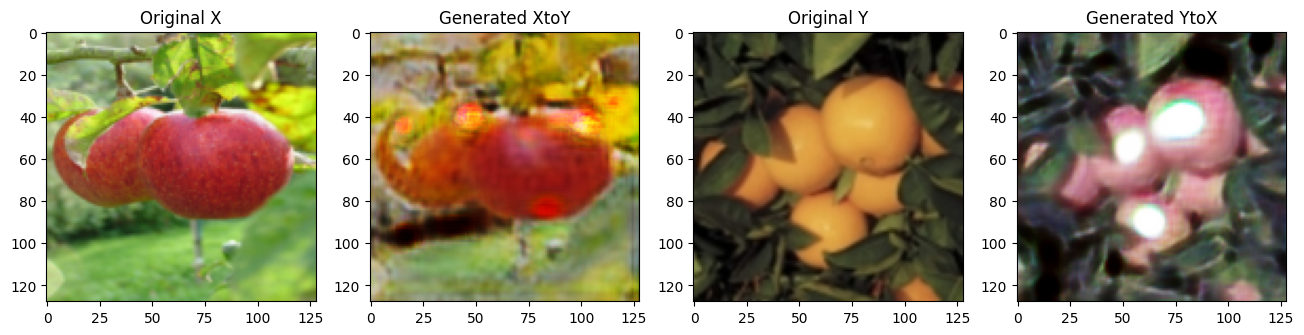

Saving checkpoint for epoch 30 at checkpoints/pytorch/apple2orange
Time taken for epoch 30 is 82.03817129135132 sec

----------------------------------


In [ ]:
import time
from tqdm import tqdm

training_steps = np.ceil((min(len(train_data_X), len(train_data_Y)) / BATCH_SIZE)).astype(int)
Dx_losses,Dy_losses, Gxy_losses,Gyx_losses = [], [],[], []

for epoch in range(1, EPOCHs + 1):

    start = time.time()
    print('Start of epoch %d' % (epoch,))

    # Reset dataloader
    iter_train_image_X = iter(train_image_loader_X) #creates an iterator from the train_image_loader_X
    iter_train_image_Y = iter(train_image_loader_Y)

    # Initialize losses
    G_XtoY_loss_mean = 0
    G_YtoX_loss_mean = 0
    Dx_loss_mean = 0
    Dy_loss_mean = 0

    for step in tqdm(range(training_steps)):

        real_image_X = next(iter_train_image_X).to(device) #batch of 10 elements
        real_image_Y = next(iter_train_image_Y).to(device)

        # ============================
        # Compute the discriminator loss
        # ============================
        # Generate fake images for discriminators

        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)

        # Compute the discriminator loss using the latest fake images

        loss_D_X = discriminator_loss(Dx(real_image_X), Dx(fake_image_X))
        loss_D_Y = discriminator_loss(Dy(real_image_Y), Dy(fake_image_Y))

        # ============================
        # Update discriminators
        # ============================
        Dx_optimizer.zero_grad()
        Dy_optimizer.zero_grad()

        loss_D_X.backward()
        loss_D_Y.backward()

        Dx_optimizer.step()
        Dy_optimizer.step()

        # ============================
        # Compute the generator loss
        # ============================
        # Generate fake images for generators

        fake_image_Y = G_XtoY(real_image_X)
        fake_image_X = G_YtoX(real_image_Y)

        # Compute the generator loss using the latest fake images

        loss_G_X_to_Y = generator_loss(Dy(fake_image_Y))
        loss_G_Y_to_X = generator_loss(Dx(fake_image_X))

        # ============================
        # Compute the cycle consistency loss
        # ============================
        # Generate cycled images using the latest fake images

        cycled_image_X = G_YtoX(G_XtoY(real_image_X))
        cycled_image_Y = G_XtoY(G_YtoX(real_image_Y))

        # Compute the cycle consistency loss using the latest cycled images

        cycle_loss_x = cycle_consistency_loss(real_image_X, cycled_image_X)
        cycle_loss_y = cycle_consistency_loss(real_image_Y, cycled_image_Y)

        # ============================
        # Compute the identity loss
        # ============================
        # Generate identity images using the latest fake images

        identity_X = G_YtoX(real_image_X)
        identity_Y = G_XtoY(real_image_Y)

        # Compute the identity loss using the latest identity images

        identity_loss_X = identity_loss(real_image_X,identity_X)
        identity_loss_Y = identity_loss(real_image_Y,identity_Y)

        # ============================
        # Combine all generator losses
        # ============================

        combined_loss = loss_G_X_to_Y+loss_G_Y_to_X + cycle_loss_x +cycle_loss_y + identity_loss_X+identity_loss_Y

        # ============================
        # Update generators
        # ============================

        G_XtoY_optimizer.zero_grad()
        G_YtoX_optimizer.zero_grad()

        combined_loss.backward()

        G_XtoY_optimizer.step()
        G_YtoX_optimizer.step()

        # Add losses

        G_XtoY_loss_mean += loss_G_X_to_Y
        G_YtoX_loss_mean += loss_G_Y_to_X
        Dx_loss_mean += loss_D_X
        Dy_loss_mean += loss_D_Y

    clear_output(wait=True)
    # ============================
    # Print loss values at the end of an epoch
    # ============================

    Dx_losses.append(loss_D_X)
    Dy_losses.append(loss_D_Y)
    Gxy_losses.append(loss_G_X_to_Y)
    Gyx_losses.append(loss_G_Y_to_X)
    print(f"G_XtoY Loss :  {G_XtoY_loss_mean/training_steps:.4f} and G_YtoX Loss :  {G_YtoX_loss_mean/training_steps:.4f} ")
    print(f"Dx Loss :  {Dx_loss_mean/training_steps:.4f} and Dy Loss :  {Dy_loss_mean/training_steps:.4f} ")

    # ============================
    # Using consistent images (sample_X and sample_Y), plot the progress of the training using both generators
    # ============================

    generated_sample_XtoY = generate_images(G_XtoY,sample_X)
    generated_sample_YtoX = generate_images(G_YtoX,sample_Y)

    plot_images(sample_X, generated_sample_XtoY,sample_Y, generated_sample_YtoX)


    # ============================
    # Save the checkpoint for every SAVE_EVERY_N_EPOCH epoch
    # ============================
    if epoch % SAVE_EVERY_N_EPOCH == 0:


        save_training_checkpoint(epoch)

        print ('Saving checkpoint for epoch {} at {}'.format(epoch,
                                                             checkpoint_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch,
                                                      time.time()-start))
    print("----------------------------------")
    gc.collect()

Well... Orange2Apple seem to work better than Apple2Orange.
We can wonder if the tuning of hyperparameters could help better this translation.

We can also plot the losses :

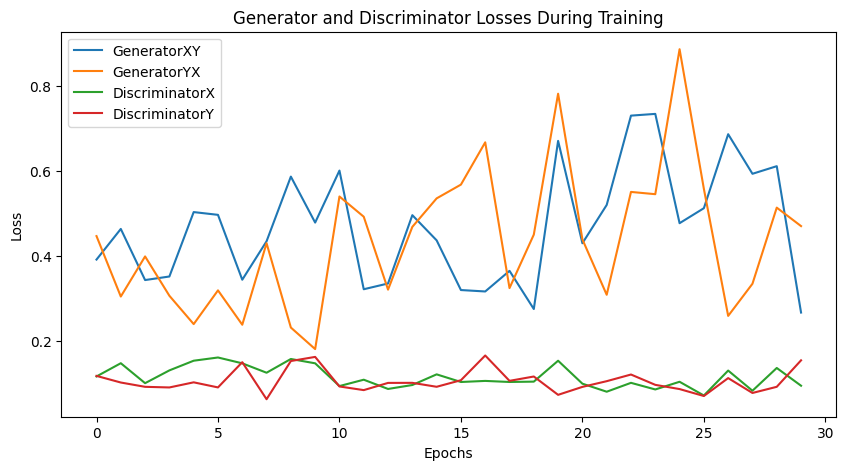

In [ ]:
Gxy_losses_cpu = [tensor.cpu().detach().numpy() for tensor in Gxy_losses]
Gyx_losses_cpu = [tensor.cpu().detach().numpy() for tensor in Gyx_losses]
Dx_losses_cpu = [tensor.cpu().detach().numpy() for tensor in Dx_losses]
Dy_losses_cpu = [tensor.cpu().detach().numpy() for tensor in Dy_losses]

# Plot train losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(Gxy_losses_cpu,label="GeneratorXY")
plt.plot(Gyx_losses_cpu,label="GeneratorYX")
plt.plot(Dx_losses_cpu,label="DiscriminatorX")
plt.plot(Dy_losses_cpu,label="DiscriminatorY")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The Generator Losses are very oscillating !
Bigger batches, and other learning rates would probably make better results.

# V. Testing

Let's randomly plot some outputs.

In [ ]:
import random

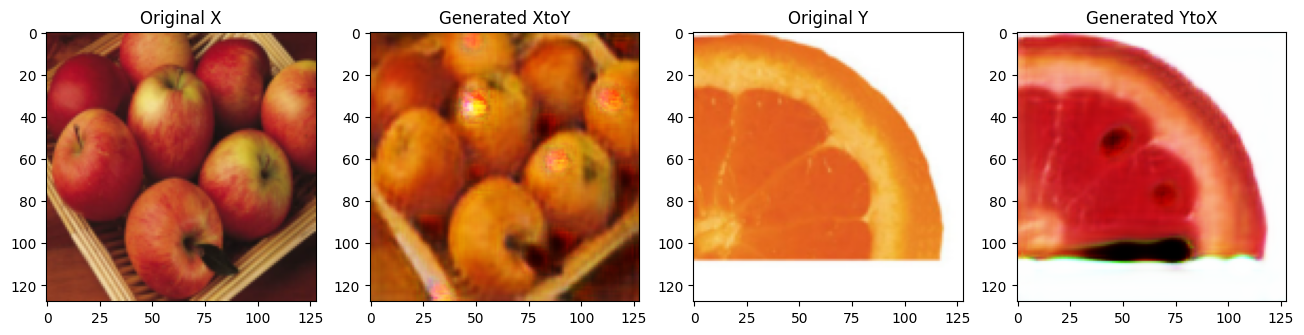

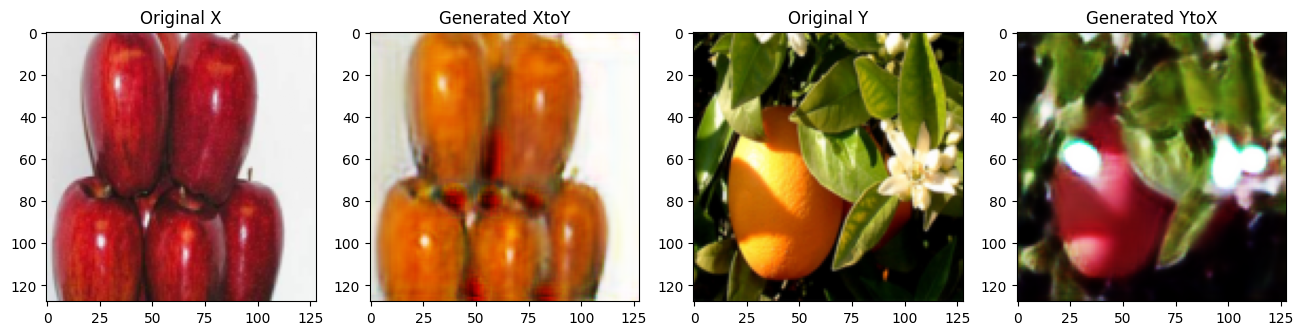

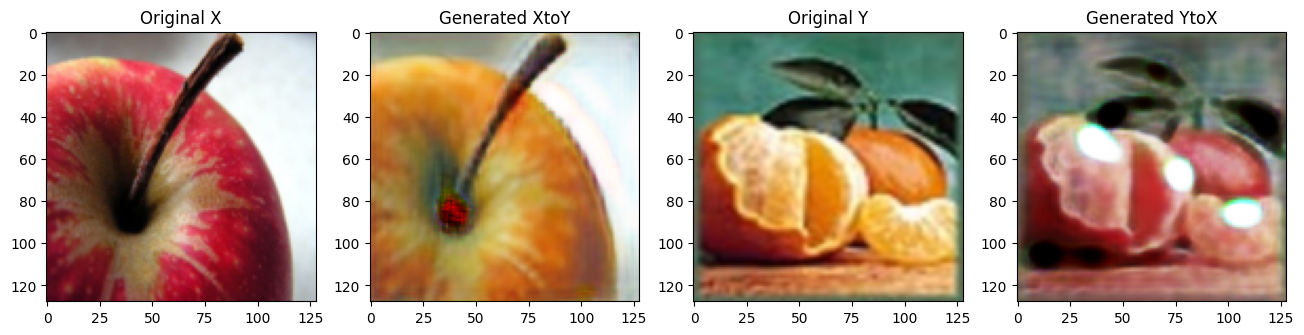

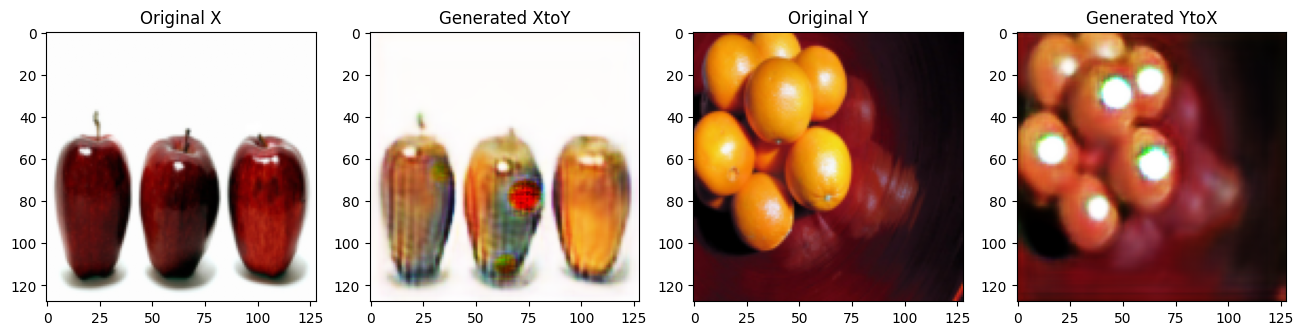

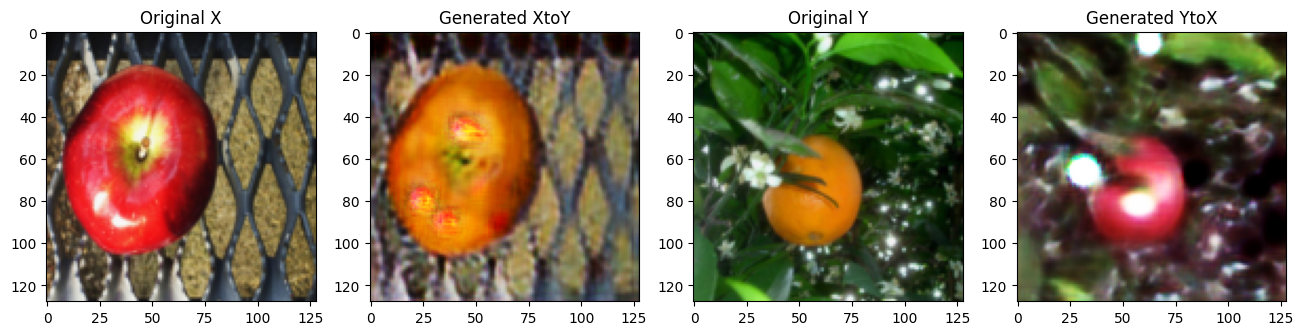

In [ ]:
for _ in range(5):

  random_X_file = random.choice(test_data_X.filenames)
  random_Y_file = random.choice(test_data_Y.filenames)

  id_sample_X = np.where(np.array(test_data_X.filenames) == random_X_file)[0][0]
  id_sample_Y = np.where(np.array(test_data_Y.filenames) == random_Y_file)[0][0]

  sample_X = test_data_X[id_sample_X]
  sample_Y = test_data_Y[id_sample_Y]

  generated_sample_XtoY = generate_images(G_XtoY,sample_X)
  generated_sample_YtoX = generate_images(G_YtoX,sample_Y)

  plot_images(sample_X, generated_sample_XtoY,sample_Y, generated_sample_YtoX)

We can be pretty proud about the new apples generated, they seem yummy ! Nonethess, I wouldn't encourage to eat the oranges generated ;-)

The poor outputs of Apple2Orange can mayb be explained by the quality of the training data, or about some hyperparameters that are not optimized.